In [15]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [16]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

(889,)

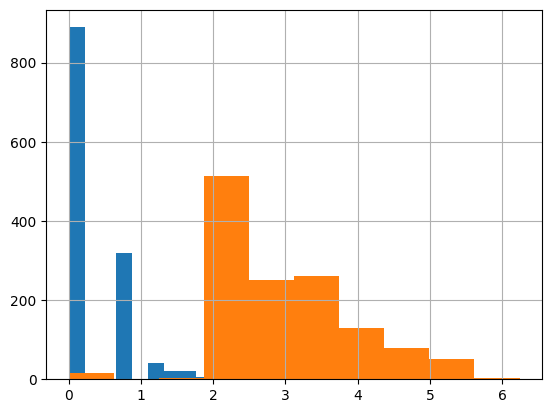

In [17]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#Fill in the NaN
all_data.Age = all_data.Age.fillna(training.Age.median())
all_data.Fare = all_data.Fare.fillna(training.Fare.median())


all_data.dropna(subset=['Embarked'],inplace = True)

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

#Convert Pclass to categorical data to get dummies
all_data.Pclass = all_data.Pclass.astype(str)

#creat dummy variables from categories 
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#prepare train data
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [18]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [20]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.81460674 0.85393258 0.79775281 0.81355932]
0.8200152351932963


In [21]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.85393258 0.82022472 0.8258427  0.80337079 0.86440678]
0.8335555132355742


In [22]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80337079 0.79213483 0.84831461 0.73595506 0.82485876]
0.8009268075922046


In [23]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())


[0.80898876 0.79213483 0.84831461 0.73595506 0.82485876]
0.8020504030978227


In [24]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.79213483 0.83146067 0.79775281 0.85310734]
0.8144416936456548


In [25]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.79775281 0.80898876 0.82022472 0.85310734]
0.8099473116231829


In [26]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [27]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [28]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [29]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [30]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGB
Best Score: 0.8549101758395226
Best Parameters: {'colsample_bytree': 0.85, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.65}


In [32]:
#As the XGB has teh highest score, the XGB model will be used

y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission1.csv', index=False)